# Modelling irregular bodies shape via ANNs
In this notebook we explore the possibility to use ANNs to represent the generic shape and density of an irregular body and be trained to reproduce a known gravitational potential field.

To get statically stable asteroids we use results from MPIA work by Francesco Biscani obtained during simulation of protoplanetary formation made by large n-body simulations. Data are included as a submodule in the git project.

To run this notebook create a conda environment using the following commands:
```
 conda create -n geodesyann python=3.8 ipython scikit-learn numpy h5py matplotlib
 conda install -c open3d-admin open3d
```

And you will need pytorch (CPU is enough) for the ANN part


In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

from torch import nn
import torch
# For debugging and development purposes this is now set to float64 ... change for speed on GPUs
torch.set_default_tensor_type(torch.DoubleTensor)

%matplotlib notebook

# Loading and visualizing an asteroid as a point cloud

In [2]:
# We import the data from MPIA containing pseudo-stable asteroid shapes
f = h5py.File('sample_vis_data/sample_01/state_10567.hdf5','r')
f2 = h5py.File('sample_vis_data/sample_01/global.hdf5', 'r')

In [3]:
# The file state_ ... contains the positions of all particles as well as the indices
# of those belonging to a cluster. Here we extract the largest ones.
dims = [(len(f[cluster][()]), cluster) for cluster in f.keys() if 'cluster' in cluster]
largest_clusters = sorted(dims,reverse=True)

In [4]:
# We have ordered the largest asteroids, we now extract positions for one in particular
rank = 4
print("Target: ", largest_clusters[rank][1])
# The particles idxs for this cluster
idx = f[largest_clusters[rank][1]][()]
# The particle radius
radius = f2['radius'][()]
# Particle positions
x_raw = f['x'][()][idx]
y_raw = f['y'][()][idx]
z_raw = f['z'][()][idx]
print("Diameter: ", 2 * radius)

Target:  cluster_2400
Diameter:  0.00043088693800637674


In [5]:
from sklearn.neighbors import NearestNeighbors
# We put xyz in a different shape (point_cloud)
point_cloud = np.append(x_raw, np.append(y_raw,z_raw))
point_cloud = point_cloud.reshape((3,len(x_raw)))
point_cloud = np.transpose(point_cloud)

nbrs = NearestNeighbors(n_neighbors=4, algorithm='ball_tree').fit(point_cloud)
distances, indices = nbrs.kneighbors(point_cloud)

print("Minimum distance between particles: ", min(distances[:,1]))
print("Maximum distance between particles: ", max(distances[:,1]))

# We take out particles that are not "touching" at least two neighbours
unstable_points = np.where(distances[:, 3]> 2 * radius * 1.01)[0]
print("Number of unstable points: ", len(unstable_points))
x = np.delete(x_raw, unstable_points, 0)
y = np.delete(y_raw, unstable_points, 0)
z = np.delete(z_raw, unstable_points, 0)

Minimum distance between particles:  0.00042108838275198475
Maximum distance between particles:  0.0005132013991266676
Number of unstable points:  5


In [6]:
# We subtract the mean so that the origin is the center of figure
x = x - np.mean(x)
y = y - np.mean(y)
z = z - np.mean(z)
# We normalize so that the axes are at most one
max_value = max([max(abs(it)) for it in [x,y,z]])
x = x / max_value
y = y / max_value
z = z / max_value
plot_radius = radius /  max_value  * 3000
# We put xyz in a different shape (point_cloud)
point_cloud = np.append(x, np.append(y,z))
point_cloud = point_cloud.reshape((3,len(x)))
point_cloud = np.transpose(point_cloud)

### Visualization via matplotlib

<IPython.core.display.Javascript object>


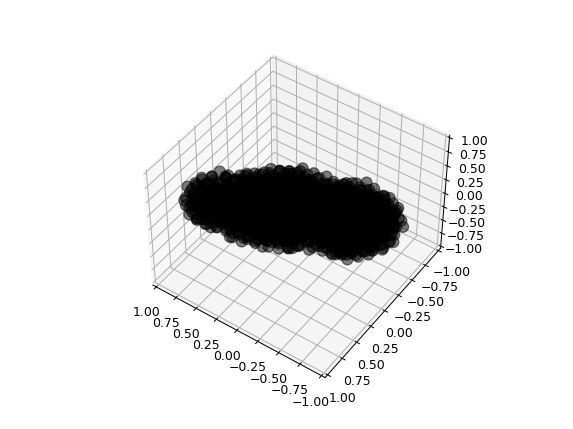

In [7]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1, projection='3d')

# We color the points w.r.t. their distance to the center
color = [np.linalg.norm([point]) for point in point_cloud] 
# And visualize the masses
ax = plt.axes(projection='3d')
ax.scatter(x, y, z, color = 'k', s = plot_radius/2, alpha=0.5)
ax.set_xlim([-1,1])
ax.set_ylim([-1,1])
ax.set_zlim([-1,1])
ax.view_init(elev=45., azim=125.)

### Visualization via open3d

In [8]:
import numpy as np
import open3d as o3d

colors = np.exp(-np.array(color))
colors = np.append(np.append(colors, colors), colors).reshape((3, len(color))).transpose()

pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(point_cloud)
pcd.colors = o3d.utility.Vector3dVector(colors)


hull, _ = pcd.compute_convex_hull()
hull_ls = o3d.geometry.LineSet.create_from_triangle_mesh(hull)
hull_ls.paint_uniform_color((1, 0, 0))
o3d.visualization.draw_geometries([pcd, hull_ls])

# Computing the gravitational potential of an asteroid (point cloud) in a point 
The Canvendish constant is not included (or $G=1$), so that we have:
$$
U_L = - \sum_{i=1}^N \frac{m_i}{|\mathbf x - \mathbf r_i|}
$$
where, assuming the asteroid with a unitary mass $m_i = 1/N$, hence:
$$
U_L = - \frac 1N \sum_{i=1}^N \frac{1}{|\mathbf x - \mathbf r_i|}
$$

In [9]:
def U_L(r, point_cloud):
    retval=torch.empty(len(r),1)
    # Only for the points inside we accumulate the integrand (MC method)
    for i, radius in enumerate(r):
        retval[i] = torch.mean(1./torch.norm(torch.sub(point_cloud,radius), dim=1))
    return - retval 

In [10]:
tcp = torch.tensor(point_cloud)
r = torch.rand(100,3)

In [11]:
%timeit U_L(r, point_cloud=tcp)

56.8 ms ± 2.89 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


# Representing the asteroid via a neural network


## Approach N.1: A FFNN represents the asteroid surface
In this approach we try to represent the asteroid minimalistically via its surface. Assuming an internal uniform density we will then be able to compute the potential generated at some point.

The FFNN will get three inputs (expressing in a continuous fashion a direction as a unit vector) and output the distance of the asteroid surface from the origin in that particular direction.

In [16]:
def weights_init(m):
    if isinstance(m, nn.Linear):
        nn.init.uniform_(m.weight.data, -1, 1)
        nn.init.uniform_(m.bias.data, -0.1, 0.1)

# Initializing a FFNN with three inputs (cartesian components of the unit direction vector) 
# and one output (the asteroid radius)
model = nn.Sequential(
          nn.Linear(3,10),
          nn.Tanh(),
          nn.Linear(10,10),
          nn.Tanh(),
          nn.Linear(10,10),
          nn.ReLU(),
          nn.Linear(10,1),
          nn.Sigmoid(),
        )

# Applying our weight initialization
_ = model.apply(weights_init)



In [17]:
# Creating N equally spaced unit vectors on a sphere (to then plot r)
N = 40
inputs = []
u, v = torch.meshgrid((torch.linspace(0., 1., N), torch.linspace(0, 1, N)))
theta, phi = 2 * np.pi * u, torch.acos(2.*v-1.)
x = torch.sin(phi)*torch.cos(theta)
y = torch.sin(phi)*torch.sin(theta)
z = torch.cos(phi)
inputs = torch.cat((x.view(-1,1),y.view(-1,1), z.view(-1,1)), dim = 1)


In [18]:
# For plotting no gradients are needed
r = model(inputs).detach()

<IPython.core.display.Javascript object>


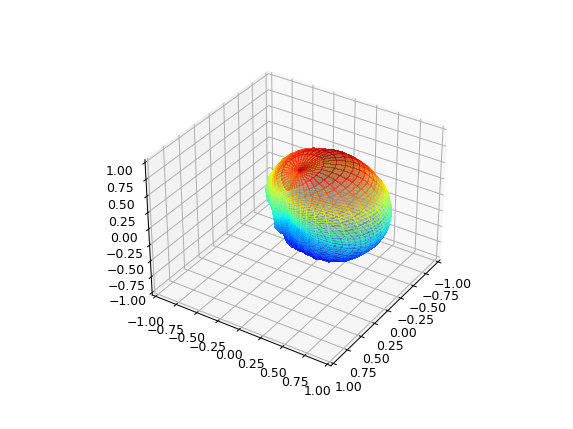

(-1.0, 1.0)

In [19]:
# We plot the visual representation of the asteroid
THETA, PHI = theta, phi
R = r.view((N,N))

X = R * torch.sin(PHI) * torch.cos(THETA)
Y = R * torch.sin(PHI) * torch.sin(THETA)
Z = R * torch.cos(PHI)
fig = plt.figure()
ax = fig.add_subplot(1,1,1, projection='3d')
plot = ax.plot_surface(
    X.numpy(), Y.numpy(), Z.numpy(), rstride=1, cstride=1, cmap=plt.get_cmap('jet'),
    linewidth=0, antialiased=False, alpha=0.5)
ax.set_xlim([-1,1])
ax.set_ylim([-1,1])
ax.set_zlim([-1,1])

## Computing the gravitational potential of the asteroid ANN model

We have a representation of the asteroid surface (and hence volume) given by our ANN, we may then assume a uniform internal density and  compute the resulting potential at a given point $\mathbf x$ as:

$$
U_P = \int_V \rho \frac1{|\mathbf r - \mathbf x|} dV = \rho \int_V \frac{dV}{|\mathbf r - \mathbf x|} 
$$

to compute the integral we use Monte Carlo integration methods, that is we sample N points in a volume V = [-1,1]x[-1,1]x[-1,1] that we know contains our asteroid (as ensured by the sigmoid activation function of the last layer). We then approximate:

$$
U_P(\mathbf x) = \rho\frac V N  \sum_i^N \left\{\begin{array}{ll}\frac{1}{|\mathbf r_i - \mathbf x|} & \mbox{inside the asteroid} \\ 0 &  \mbox{otherwise}  \end{array}\right.
$$

Since $\rho = \frac MV$ is itself an integral being $V = \int_V dV \approx \frac N{N_{in}V}$ we get:

$$
U_P(\mathbf x) = \frac 1{N_{in}}  \sum_i^N \left\{\begin{array}{ll}\frac{1}{|\mathbf r_i - \mathbf x|} & \mbox{inside the asteroid} \\ 0 &  \mbox{otherwise}  \end{array}\right.
$$

In [20]:
def U_P(r, model, N = 300):
    # We generate randomly 300 points in the [-1,1]^3 bounds
    points = torch.rand(N,3) * 2 - 1
    # We compute their norms
    norms = torch.norm(points, dim=1)
    # We compute if they are inside or outside the asteroid represented by the FFNN model
    inside = norms.view(-1,1) < model(points/norms.view(-1,1))
    # Only for the points inside we accumulate the integrand (MC method)
    retval = torch.sum(1./torch.norm(r - points[inside.view(-1,)], dim=1))
    return  - retval / torch.sum(inside)

In [21]:
# Helper class to represent a sphere model
class sphere:
    def __init__(self, N = 300):
        self.N = N
    def __call__(self, x):
        return torch.ones(self.N,1)

spherical_asteroid = sphere(N = 3000)
NN_asteroid = model

target_r = torch.tensor([[1.,1.,1.]])

# We print the values of the potential in r of a sphere, of the ground truth asteroid (point cloud)
# and of the asteroid as represented by the NN
print("Potential of the asteroid represented by the NN (MC): ", U_P(target_r, NN_asteroid, N=3000).item())
print("Potential of a spherical asteroid (MC): ", U_P(target_r, spherical_asteroid, N=3000).item())
print("Potential of a spherical asteroid (Real): ", (-1./torch.norm(target_r)).item())
print("Potential of the point cloud: (Real)", U_L(target_r, point_cloud=tcp)[0][0].item())

Potential of the asteroid represented by the NN (MC):  -0.5987290321682037
Potential of a spherical asteroid (MC):  -0.5755055019505035
Potential of a spherical asteroid (Real):  -0.5773502691896258
Potential of the point cloud: (Real) -0.6077760177440209


In [22]:
# All good, but can we get the gradient of the above potential w.r.t. the weights? -> NOPE
# So the only way to evolve this network is EVOLUTION!!!
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "https://insight-quality.com/wp-content/uploads/2018/04/problem.jpg")

## Approach N.2: A FFNN represents the asteroid density
In this approach we try to represent the asteroid density $\rho$ directly! This may seem worse
but, in terms of gradients, leads to a more learnable problem.

In [27]:
# Network architecture
def weights_init(m):
    if isinstance(m, nn.Linear):
        nn.init.uniform_(m.weight.data, -1, 1)
        nn.init.uniform_(m.bias.data, -0.1, 0.1)

# Initializing a FFNN with four inputs and one output (the density).
# The four inputs are ix, iy, iz, r corresponding to the cartesian point P = r [ix, iy, iz]
model = nn.Sequential(
          nn.Linear(4,30),
          nn.ReLU(),
          nn.Linear(30,30),
          nn.ReLU(),
          nn.Linear(30,30),
          nn.ReLU(),
          nn.Linear(30,30),
          nn.ReLU(),
          nn.Linear(30,10),
          nn.ReLU(),
          nn.Linear(10,1),
          nn.Sigmoid(),
        )

# Applying our weight initialization
_  = model.apply(weights_init)

In [28]:
# Converts a cartesian position x,y,z into a network input ix, iy, iz, r
def cart2inputs(x):
    unit_x = x / torch.norm(x,dim=1).view(-1,1)
    return torch.cat((unit_x, torch.norm(x,dim=1).view(-1,1)), dim=1)

In [29]:
# To visualize the network output in the box [-1,1]^3 we compute the NN output on a grid 
x = torch.linspace(-1,1,20)
y = torch.linspace(-1,1,20)
z = torch.linspace(-1,1,20)
X, Y, Z = torch.meshgrid((x,y,z))
nn_inputs = torch.cat((X.reshape(-1,1), Y.reshape(-1,1), Z.reshape(-1,1)), dim=1)
nn_inputs = cart2inputs(nn_inputs)
RHO = model(nn_inputs).detach()


<IPython.core.display.Javascript object>


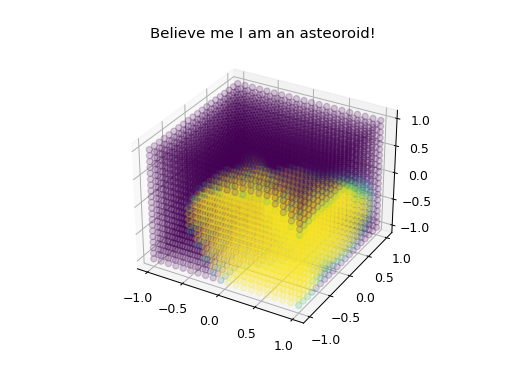

Text(0.5, 0.92, 'Believe me I am an asteoroid!')

In [30]:
# Here we plot it
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X.reshape(-1,1), Y.reshape(-1,1), Z.reshape(-1,1), marker='.', c=RHO, s=100, alpha=0.2)
plt.title("Believe me I am an asteoroid!")

## Computing the gravitational potential of the asteroid ANN model
Having the mass density $\rho$ we may now compute the potential field via a monte carlo integration approach.
In the naive implementation, we will sample at random $N$ points to compute:
$$
U_P = - \int_V \frac\rho r dV 
$$
The volume V is the cube $[-1,1]^3$, with a volume of 8. We thus approximate the above integral as:
$$
U_P(\mathbf r) \approx \frac 8N \sum_i \frac {\rho_i}{|\mathbf r-\mathbf x_i|} 
$$
where $\mathbf x_i$ are $N$ uniformly randomly sampled within the cube -> PLEASE IMPROVE ME!

In [31]:
# This computes the potential at the points r (e.g. torch.tensor([[np.sqrt(2),np.sqrt(2),0], [10,0,0]]))
# from the model
def U_P2(r, model, N = 3000):
    # We generate randomly points in the [-1,1]^3 bounds
    mc_points = torch.rand(N,3) * 2 - 1
    nn_inputs = cart2inputs(mc_points)
    rho = model(nn_inputs)
    retval=torch.empty(len(r),1)
    # Only for the points inside we accumulate the integrand (MC method)
    for i, radius in enumerate(r):
        retval[i] = torch.sum(rho/torch.norm(radius - mc_points, dim=1).view(-1,1)) / N
    return  - 8 * retval

In [48]:
# The dataset is here produced. It consists on the values of the potentials in 100 points radnomly
# sampled around the asteroid and excluding those that are potentially inside.
targets = (torch.rand(100,3)*2-1)*1.1
targets[torch.norm(targets, dim=1) > 1]
labels = U_L(targets, tcp)

# Here we set some details of the training
loss_fn = torch.nn.MSELoss()
learning_rate = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

### Here we perform steps of gradient descent
Let it run up to when its < 1e-3 to actually see something that resembles the original asteroid. When stuck increase the number of monte carlo samples or play around the learning rate.

In [49]:
for i in range(5000):
    # Compute the loss
    predicted = U_P2(targets, model, N=30000)
    loss = loss_fn(predicted, labels)
    print(i, loss.item())
    # Before the backward pass, use the optimizer object to zero all of the
    # gradients for the variables it will update (which are the learnable
    # weights of the model). This is because by default, gradients are
    # accumulated in buffers( i.e, not overwritten) whenever .backward()
    # is called. Checkout docs of torch.autograd.backward for more details.
    optimizer.zero_grad()

    # Backward pass: compute gradient of the loss with respect to model
    # parameters
    loss.backward()

    # Calling the step function on an Optimizer makes an update to its
    # parameters
    optimizer.step()

0 0.0013790876514552983
1 0.0013794249493840397
2 0.006140585797034047
3 0.0012909324341031808
4 0.002670417806884942
5 0.0011929220002132315
6 0.0017983733154439375
7 0.001473118337826515
8 0.0018210037523730227
9 0.002879434927289266
10 0.0037684376104805163
11 0.0027398450318339967
12 0.0021095164576577187
13 0.0013481713776749618
14 0.0021333705184457584
15 0.002130132980891326
16 0.0013089343270196211
17 0.0016475122605810039
18 0.0015105616191403992
19 0.0018439896346103696
20 0.0014820708959005337
21 0.001288446254035246
22 0.0016357270646466249
23 0.0020646857308759038
24 0.003952612629989363
25 0.001705013662820057
26 0.004442801415736373
27 0.0015403407861687903
28 0.0015427328294232298
29 0.0016805361837769145
30 0.0015244073160281023
31 0.0016784579269813174
32 0.0015507785138384924
33 0.0011430256320371006
34 0.0024378518986267915
35 0.0035013727308946686
36 0.0019623331474722923
37 0.0013226241846274727
38 0.0015481951022753052
39 0.0017719115243657155
40 0.00132799003425

323 0.0008192839056105484
324 0.0010883326119377299
325 0.0016006941114591945
326 0.001093257746684206
327 0.0010528522298784817
328 0.0009635635501590227
329 0.0014611669951139434
330 0.0024992445313865284
331 0.0015906235553618379
332 0.001084691294282791
333 0.001214996844579722
334 0.0008286724035951932
335 0.0014624708966945402
336 0.0010200931794251405
337 0.0009690062244644709
338 0.0012558263920448168
339 0.0012645905175370873
340 0.0011065097212208958
341 0.000953284951022726
342 0.0011465728598069708
343 0.001096404487926318
344 0.0011853873360734258
345 0.00096742801344618
346 0.0010197459916585923
347 0.0017572692732009303
348 0.000883452730182575
349 0.0008541908278486455
350 0.0008701469563886257
351 0.0008291594587731263
352 0.001339208056169214
353 0.003020733826971177
354 0.0014185164921620013
355 0.0009307399999112032
356 0.0009072202625019405
357 0.0008809273572165957
358 0.001051118738598138
359 0.0010068681571387779
360 0.0010454139481850346
361 0.00099969487634515

641 0.0006736323306474247
642 0.0006642535855394745
643 0.0008955284659910882
644 0.0007610977970192975
645 0.0012673074638884416
646 0.0009044443760081258
647 0.000979997976169051
648 0.0014892999119652684
649 0.0007391011237187411
650 0.0006298900948269441
651 0.0006692786878375981
652 0.0006307691476252375
653 0.0012432236979461914
654 0.0007871028240280018
655 0.0007469354394237783
656 0.0013909413896625925
657 0.0006996598809703152
658 0.0011176040098560462
659 0.0016355103111571517
660 0.0006482780183032821
661 0.0006866034063397885
662 0.0007499515537260987
663 0.0031164249970967554
664 0.0011468180943150306
665 0.0006916612625440986
666 0.000555824977495974
667 0.001933476475709277
668 0.001144060848555922
669 0.0009244726550165851
670 0.0008215107520112834
671 0.0008938729426836635
672 0.00135259397838613
673 0.0005927978885587729
674 0.0008836342308129588
675 0.0011504192592164666
676 0.0006829201012107674
677 0.0006262639424696706
678 0.0006985221237972825
679 0.000998207608

959 0.0005991813334358027
960 0.0011591407000060903
961 0.0005525440551457635
962 0.0013632615560954348
963 0.0011281117477695108
964 0.0010395435031597955
965 0.001741944349277482
966 0.0024794611810896733
967 0.0013119652201388824
968 0.0005875768927501018
969 0.0012474718154488788
970 0.000838383408980401
971 0.0004982459025432373
972 0.0011034425191056131
973 0.0009530685428986549
974 0.0006771224751382124
975 0.0008140783279145169
976 0.0008146702948148961
977 0.0008906074805366904
978 0.00067801006308087
979 0.0005900272395190641
980 0.0006287753044632036
981 0.0011417849611668534
982 0.001263012199620016
983 0.0007392707474291906
984 0.0009572743248818941
985 0.0005453760732395463
986 0.0007790490139425518
987 0.0011328818925195154
988 0.0008470003380272163
989 0.00053184269323174
990 0.0006507716004896407
991 0.0010591520819730805
992 0.0013030247230122213
993 0.00047404873637986125
994 0.0005536456538720562
995 0.0004924407839471001
996 0.0005599086908790325
997 0.000914709980

1266 0.00047625892337574367
1267 0.0016933416790455014
1268 0.0005258001964530332
1269 0.0009172090819294132
1270 0.0006636299833521111
1271 0.0004941294260292669
1272 0.0006423159849748161
1273 0.00046098139302515404
1274 0.0006798351960452323
1275 0.00048390252622808967
1276 0.0005891246119955877
1277 0.0007103517613396221
1278 0.0007289109097255281
1279 0.00048336110445826996
1280 0.0008358449700332513
1281 0.0004902629379050103
1282 0.0004565748079109016
1283 0.0004711314677319578
1284 0.000595905923875295
1285 0.0005930037699538053
1286 0.0011722562716983296
1287 0.0009676082113946604
1288 0.00037205129275937526
1289 0.0005848729039909344
1290 0.0006353443441119403
1291 0.0006155751112831104
1292 0.0019598023701311753
1293 0.0009475535142424333
1294 0.000524122042880062
1295 0.000433184615081922
1296 0.00039508367996690815
1297 0.0011323187421999007
1298 0.0005999211136769306
1299 0.0007316224197451859
1300 0.0009687543042939425
1301 0.002236479084048849
1302 0.0006128658393375701

1570 0.0012897090412961362
1571 0.0010826795942689448
1572 0.00040681605481792055
1573 0.0015752744191265171
1574 0.0004926095218212054
1575 0.0005115312466460914
1576 0.002981060043249947
1577 0.00046465903392890734
1578 0.001227248343016932
1579 0.0010465528054712072
1580 0.0004529348453482067
1581 0.0017532609553642874
1582 0.0007958364706498656
1583 0.0005555864903657967
1584 0.00042573288880283136
1585 0.001024888922032569
1586 0.0014412084720151876
1587 0.000454883279050807
1588 0.0005734214883276734
1589 0.000558172131298478
1590 0.00039491487653069965
1591 0.0008058510421019853
1592 0.0015316783854018572
1593 0.0011648662779832598
1594 0.0004205871228480394
1595 0.00040675849675618546
1596 0.0005428847691488956
1597 0.0006531944092373934
1598 0.0004626637829142524
1599 0.00043845154813476747
1600 0.00036062065639741887
1601 0.0003664161264715489
1602 0.0009465082443827503
1603 0.001319907775831561
1604 0.0005169950442902125
1605 0.00041977904816889775
1606 0.0008674225077700464

1874 0.0007440455540106154
1875 0.0004206254031029747
1876 0.001338068913037212
1877 0.0019869754263395125
1878 0.0004479340555204881
1879 0.0008045187137541769
1880 0.00036374130009828693
1881 0.00038245709626742475
1882 0.0017026634252622658
1883 0.0007093926586971114
1884 0.0008898589305036827
1885 0.0007508164565232992
1886 0.0018322501934419277
1887 0.0013186922840489218
1888 0.0006026838427985661
1889 0.0015784730448819252
1890 0.000359207122200047
1891 0.0012013308816287071
1892 0.0003796700204670746
1893 0.00042064224272782725
1894 0.0012754653164760688
1895 0.0015830804008715124
1896 0.0009524080727898467
1897 0.0003846286894495448
1898 0.0003544532052908903
1899 0.000648271839624851
1900 0.0004633625315578
1901 0.0007193439809610984
1902 0.0004294460949242711
1903 0.0010488869289348862
1904 0.0003023527780757562
1905 0.00037131238240898225
1906 0.00042070674562535407
1907 0.0004310654056123378
1908 0.0006772041968201191
1909 0.0004118275662294481
1910 0.000314802130726609
191

2178 0.0004199516716669048
2179 0.0003677180630629785
2180 0.00033999052790014756
2181 0.0003651836457417092
2182 0.0003189733731385567
2183 0.0008043257973943326
2184 0.0006342576625281445
2185 0.0022172251278252428
2186 0.0003604407426361479
2187 0.0006140987589695199
2188 0.00035856894645869183
2189 0.000856125380622006
2190 0.0032601156217213828
2191 0.000323882936160713
2192 0.00037237257951417064
2193 0.0002857193585195337
2194 0.00027836807389659146
2195 0.0005526285687741516
2196 0.00044688310874139346
2197 0.0005320445949982443
2198 0.0003256094162265505
2199 0.0007453819635960168
2200 0.0011886062339350719
2201 0.001158920268433423
2202 0.00038650866517457957
2203 0.00036109377444349733
2204 0.0008822821277939534
2205 0.00023642326377110994
2206 0.00042994996061524273
2207 0.0003463273596680971
2208 0.00031003692084079454
2209 0.0005437423985277476
2210 0.0003654863869105328
2211 0.0007831657229125676
2212 0.0004731793132499724
2213 0.0005886110105245337
2214 0.00022681381908

2481 0.0009242886928249885
2482 0.0008348046901162524
2483 0.0011356674648203495
2484 0.000805833228736883
2485 0.0008715581320418982
2486 0.0014714230865036724
2487 0.0005267836419338913
2488 0.00029916272806481054
2489 0.00043898758417042655
2490 0.0005039204622860268
2491 0.000269776492434504
2492 0.0008163169997679749
2493 0.0002739052517524182
2494 0.00033388016745957783
2495 0.0007078230542857854
2496 0.0002871787938651947
2497 0.0004605337988963457
2498 0.0012965669427294558
2499 0.0010013123703648697
2500 0.0021825286949212178
2501 0.0012221837556086656
2502 0.0003778165839261981
2503 0.0005570408811566859
2504 0.0005010351005660634
2505 0.0007937433040883022
2506 0.0031439021006993916
2507 0.0009351231792234432
2508 0.00027773405583616763
2509 0.0036916739449803708
2510 0.00026837796395005604
2511 0.0002775397073843945
2512 0.0010257922947761314
2513 0.00031725314662879784
2514 0.0008371442414712621
2515 0.0032269691576945004
2516 0.0005020086751379258
2517 0.00165458731993358

2784 0.0003076288200225286
2785 0.0008727112859765147
2786 0.0012834193867596682
2787 0.0034329733071540025
2788 0.0006077062058841436
2789 0.0002933005174196919
2790 0.00036065356937924216
2791 0.00036714121816776806
2792 0.000699210858667004
2793 0.0002829063151496301
2794 0.0002045283540379015
2795 0.000370755651684083
2796 0.0018392686027711924
2797 0.0002981140505620478
2798 0.0009166204535643839
2799 0.00030387740651792385
2800 0.0013492490368481615
2801 0.000776414579430941
2802 0.000417818665574195
2803 0.0005785895709327039
2804 0.0008176713854797473
2805 0.002891707804588366
2806 0.0002727020458779056
2807 0.0008414594668489805
2808 0.00032480376692511724
2809 0.0002610014311211986
2810 0.00020804171286574114
2811 0.0003247409114026134
2812 0.00038175824134223423
2813 0.0007051073375160799
2814 0.0004335417118766839
2815 0.00039214742431431857
2816 0.0016890495879670034
2817 0.0003633946188440145
2818 0.0003575837186928119
2819 0.00023830641790688098
2820 0.000752330067855609

3087 0.0008160296748785716
3088 0.0003449682154781961
3089 0.00041315520576961284
3090 0.0010313931840634071
3091 0.00022543069932786232
3092 0.0005408450065997766
3093 0.00028996350745388486
3094 0.0008202049218972962
3095 0.00033182947513779137
3096 0.0004964010597260341
3097 0.00023328396450246315
3098 0.0008162411521016068
3099 0.0007401114142770146
3100 0.0003224714195501323
3101 0.0008121000408566791
3102 0.0003810881475849296
3103 0.00042518529140185107
3104 0.0005119418499566872
3105 0.0014327100013648336
3106 0.0006366478322355148
3107 0.00027801476567231736
3108 0.0002206667418447257
3109 0.0004303407086115998
3110 0.000360338264454941
3111 0.000739690315945569
3112 0.0002605926645678701
3113 0.00045416823686227016
3114 0.0003192181783472206
3115 0.00026524749387027186
3116 0.0005962502618142763
3117 0.0009460720561313781
3118 0.000260145703762777
3119 0.00040047178257641286
3120 0.0006603551334215412
3121 0.0006840045186528551
3122 0.0004097039816128828
3123 0.00287162191723

3389 0.00035964553324209833
3390 0.0013987014978471379
3391 0.00034045285582607964
3392 0.0013953996943361054
3393 0.0009946370192655584
3394 0.00033393211591229723
3395 0.0001744154989412755
3396 0.0003408353136184087
3397 0.0008289712821073148
3398 0.00041017732345641905
3399 0.000566601490606891
3400 0.0003274405265782663
3401 0.0009327146527149507
3402 0.0004199153810822445
3403 0.0006256790916756183
3404 0.0004219030437075136
3405 0.0006039858259869795
3406 0.00019633543580950712
3407 0.00024871276819083093
3408 0.0011960762359169476
3409 0.0004890117252048319
3410 0.0003011538217737575
3411 0.0002808156154847556
3412 0.0005975250862230457
3413 0.0003065822591940797
3414 0.0010693857688367039
3415 0.0020655738350494556
3416 0.0005817168883137163
3417 0.0005809728625425127
3418 0.00035714268780439034
3419 0.00027779764040753113
3420 0.0005068514817466819
3421 0.0004824810831043254
3422 0.0019217787695563265
3423 0.00023012455211084574
3424 0.0002532598078493398
3425 0.0002212629734

3691 0.002646467946971667
3692 0.00024379926671869048
3693 0.0005986989510288757
3694 0.0004851137481453731
3695 0.0005118237618474858
3696 0.00015977232840189558
3697 0.00018550794099221957
3698 0.0006129686849192309
3699 0.0008677804041316276
3700 0.00023779523706296942
3701 0.0003542452080282416
3702 0.0004186955940927127
3703 0.0005324940860655609
3704 0.0002773596182899602
3705 0.00035881879303993337
3706 0.00022326024130404895
3707 0.00021885780702090608
3708 0.00046100702327629245
3709 0.0022736690303380353
3710 0.000380717325891807
3711 0.000551271927483636
3712 0.0004700950733753487
3713 0.000264461812072363
3714 0.0014849863976860262
3715 0.0002820034408649028
3716 0.0003112519380306093
3717 0.0003657860702812797
3718 0.0018936654657117696
3719 0.0003058334236342407
3720 0.0007296002931659036
3721 0.0010201807598649347
3722 0.0005728093319454821
3723 0.0012296483374115601
3724 0.0006215639599915274
3725 0.00020567917795729116
3726 0.0003252548249777281
3727 0.0011478175436920

3993 0.0008202193372531489
3994 0.0008384227793859157
3995 0.0004752612315961099
3996 0.00022453315674453298
3997 0.000501265289567879
3998 0.00030475727852799067
3999 0.00043838964902350645
4000 0.00027666740127560083
4001 0.0002691429478741118
4002 0.0004770661572824125
4003 0.00035711251938912365
4004 0.0004204396223868146
4005 0.0004062009113259001
4006 0.00030415890632918955
4007 0.0004242220729154398
4008 0.000806541024908031
4009 0.0003809426380797572
4010 0.0002823107427415208
4011 0.0006740496412113364
4012 0.00018251524690597476
4013 0.0007250239082804706
4014 0.00019714067913968898
4015 0.0005981128363599395
4016 0.00026050756071938324
4017 0.00024155357805179023
4018 0.00029620305556123973
4019 0.001510715417639188
4020 0.00035813187035486617
4021 0.00026150410362139285
4022 0.0006792378424758951
4023 0.00040533261845053596
4024 0.00018787750667286857
4025 0.0006800380151006483
4026 0.0005743513634707977
4027 0.00035755713886085445
4028 0.0004347474097193791
4029 0.00027396

4294 0.0009014455589020287
4295 0.0024140049327705574
4296 0.0014255104359423417
4297 0.003571459138975872
4298 0.0004327339095879495
4299 0.0006669320570513142
4300 0.0009264049895722445
4301 0.0013096823229090929
4302 0.0022730261049598867
4303 0.004101706764072042
4304 0.000646801229427622
4305 0.0011099284500092816
4306 0.0003317599274199108
4307 0.0017773973560124287
4308 0.0005303065912170384
4309 0.0009986919876932621
4310 0.0007081836521093404
4311 0.0024095720161545283
4312 0.000260349216397191
4313 0.0025122201554190087
4314 0.00022781618738092226
4315 0.000636366866851755
4316 0.0014847817948753746
4317 0.001866484688508166
4318 0.0014454946310391303
4319 0.0008317465414532289
4320 0.0009181302712420427
4321 0.0011015907367593236
4322 0.0009176873421189867
4323 0.001186421302856611
4324 0.0005181389428100685
4325 0.0013523388804059196
4326 0.0009423819244020809
4327 0.00021421202442321391
4328 0.00033844998534135923
4329 0.0015787704322638273
4330 0.0009525240474283815
4331 

4596 0.0003702557570622048
4597 0.0003365968117509849
4598 0.0028616671278633675
4599 0.00027493756917466665
4600 0.00041131011043598015
4601 0.00020163845751162965
4602 0.00021890911038589084
4603 0.00038838100439759354
4604 0.00020789141415654175
4605 0.00016787270201839584
4606 0.00038773193804608795
4607 0.0006107719238954466
4608 0.00026970137782765855
4609 0.000404565353170225
4610 0.0006012508941740934
4611 0.0001810017020163515
4612 0.00024139332466909715
4613 0.00045008404282252266
4614 0.00039702128386607806
4615 0.0006623408226884359
4616 0.0002641184154782856
4617 0.00040054468062883993
4618 0.00020504652822121407
4619 0.00032038728273863247
4620 0.00034880985067975553
4621 0.0003231818740828063
4622 0.0006437513596260943
4623 0.0006054156365648549
4624 0.00071403065988647
4625 0.00029027081273818526
4626 0.0015617383046455879
4627 0.00035047352306353483
4628 0.0003305643936053781
4629 0.0003617520615836003
4630 0.0007936715320824849
4631 0.00041153774634350643
4632 0.00052

4897 0.001035890636474118
4898 0.0006384775511537898
4899 0.00047924719847642017
4900 0.00024606747138084027
4901 0.0004460666405224581
4902 0.00032955729652147574
4903 0.00022910990525400535
4904 0.00021122482933464602
4905 0.0003404806553054252
4906 0.001587022419406007
4907 0.0021505695130418652
4908 0.0006155872604891959
4909 0.000522337118095269
4910 0.0002684734908418266
4911 0.0009470303877174287
4912 0.002053871399035073
4913 0.0018353567348144732
4914 0.0011080370638315246
4915 0.00031990525315285084
4916 0.00027865450937155045
4917 0.0006148590691593367
4918 0.001345327505890578
4919 0.0003673286862337877
4920 0.00042357561389165266
4921 0.0017195003753373403
4922 0.00025573010581238573
4923 0.00028148771599451213
4924 0.0016824504142626201
4925 0.000245427103664692
4926 0.0008822187805184902
4927 0.00043348379292735563
4928 0.0002725137377916798
4929 0.0005465980488819394
4930 0.00018090554031246505
4931 0.00044183556595735744
4932 0.0003806485938240968
4933 0.00256609457958

<IPython.core.display.Javascript object>


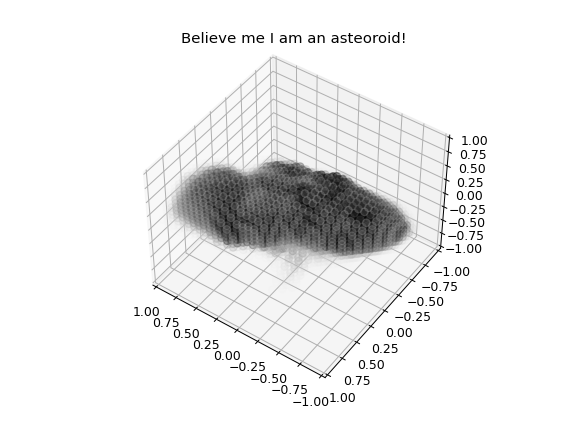

In [51]:
x = torch.linspace(-1,1,30)
y = torch.linspace(-1,1,30)
z = torch.linspace(-1,1,30)
X, Y, Z = torch.meshgrid((x,y,z))
nn_inputs = torch.cat((X.reshape(-1,1), Y.reshape(-1,1), Z.reshape(-1,1)), dim=1)
nn_inputs = cart2inputs(nn_inputs)
RHO = model(nn_inputs).detach()

colors = torch.cat((1-RHO, 1-RHO, 1-RHO, RHO), dim=1)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X.reshape(-1,1), Y.reshape(-1,1), Z.reshape(-1,1), marker='.', c=colors, s=150)
#ax.scatter(targets[:,0], targets[:,1], targets[:,2], color='y')
plt.title("Believe me I am an asteoroid!")

ax.set_xlim([-1,1])
ax.set_ylim([-1,1])
ax.set_zlim([-1,1])
ax.view_init(elev=45., azim=125.)

<IPython.core.display.Javascript object>


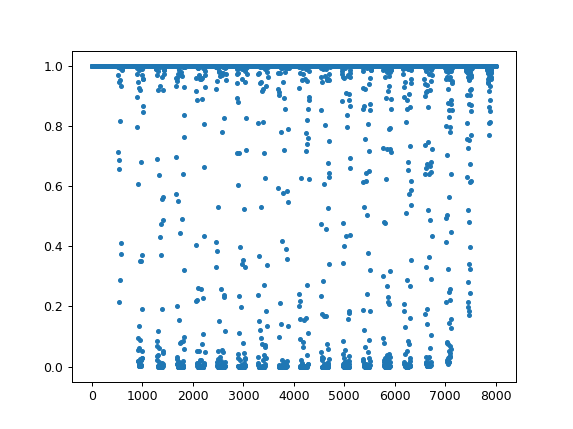

In [306]:
fig = plt.figure()
plt.plot((1-RHO).numpy(), '.')

# TODO list:

* Code efficiency -> move to GPU and make training scalable to more sample points / mc points.
* MC integration -> a better algorithm must exist to sample the points (low-discrepancy maybe?)
* Network architecture -> this is only a possible one. More depth? Different inputs? Use the NERF decomposition in harmonics?
* How to visualize and interpret the results? The matplotlib trick used here should be improved? How do we know how well the asteroid shape and internal mass distributionis learned?
* Propagate trajectories around the asteroid.
* Can we incorporate observations from real spacecraft trajectories in the loss? Or other data-fusion things?
* Training with gravity rather than potential?
* What happens for non uniform bodies? Can we prove that we are able to follow the inhomogenuities?